# Implementing eigenmode extraction of thickness variation with PCA

---

Here we evaluate the thickness eigenmodes computed by performing PCA over the complete set of high-resolution data


### package imports and basic functions

---

In [1]:
import os
import gc
import sys
import glob
import json
import random
import datetime
import importlib
import itertools
import numpy as np
from scipy import spatial
import scipy.sparse as sparse
import scipy.stats as stats
import pandas as pd
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import boto3


In [2]:
class MyNumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def ensure_dir(file_name):
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    return file_name


def list_dirs(path=os.getcwd()):
    files = glob.glob(os.path.join(path, '*'))
    files = [x for x in files if os.path.isdir(x)]
    return files


def file_exists(file_name, path_name=os.getcwd()):
    return os.path.isfile(os.path.join(path_name, file_name))


def write_json(json_obj, file_path):
    with open(file_path, 'w') as outfile:
        json.dump(json_obj, outfile, sort_keys=True, indent=4,
                  cls=MyNumpyEncoder)
    return json_obj


def load_json(file_path):
    with open(file_path, 'r') as infile:
        return json.load(infile)


def write_np(np_obj, file_path):
    with open(file_path, 'wb') as outfile:
        np.save(outfile, np_obj)


def load_np(file_path):
    with open(file_path, 'rb') as infile:
        return np.load(infile)


In [3]:
# path setting
main_dir = os.path.abspath('../../../..')
main_dir


'/mountpoint/code/projects/normative_brain_charts'

## Load high-resolution thickness data

---

In [4]:
all_thickness_data = load_np(f'{main_dir}/data/npy/thickness_all_datasets.npy');


In [5]:
all_thickness_data.shape

(2473, 59412)

## Perform PCA to construct the kernel

---

In [183]:
from sklearn.decomposition import PCA

# get all possible components
thickness_pca = PCA(n_components=all_thickness_data.shape[0])

thickness_pca.fit(all_thickness_data)

# thickness_pca_kernel = thickness_pca.transform(all_thickness_data)


PCA(n_components=2473)

In [198]:
# ensure correctness by checking the shape of all computed eigenmodes
thickness_pca.components_.shape


(2473, 59412)

In [197]:
# ensure correctness by validating that the complete set of kernels explain the total variance
np.sum(thickness_pca.explained_variance_ratio_)


1.0

In [199]:
# ensure correctness by validating that all components are vectors of unit norm
np.linalg.norm(thickness_pca.components_, axis=1)


array([1., 1., 1., ..., 1., 1., 1.])

## PCA evaluations

---

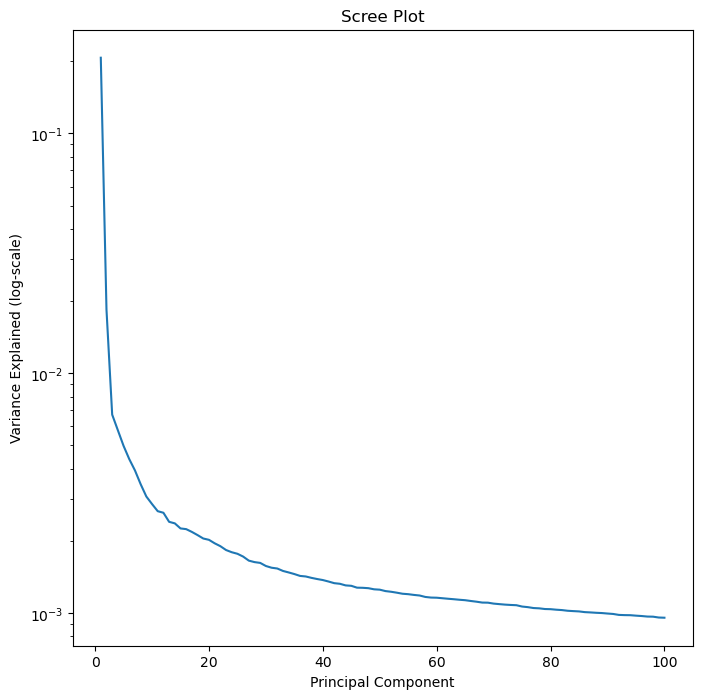

In [186]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

# number of components to visualize
n_components = 100

axes.plot(
    np.arange(n_components) + 1,
    thickness_pca.explained_variance_ratio_[:n_components],
)

axes.set_title('Scree Plot')
axes.set_xlabel('Principal Component')
axes.set_ylabel('Variance Explained (log-scale)')

axes.set_yscale('log')


Text(0, 0.5, 'Variance Explained')

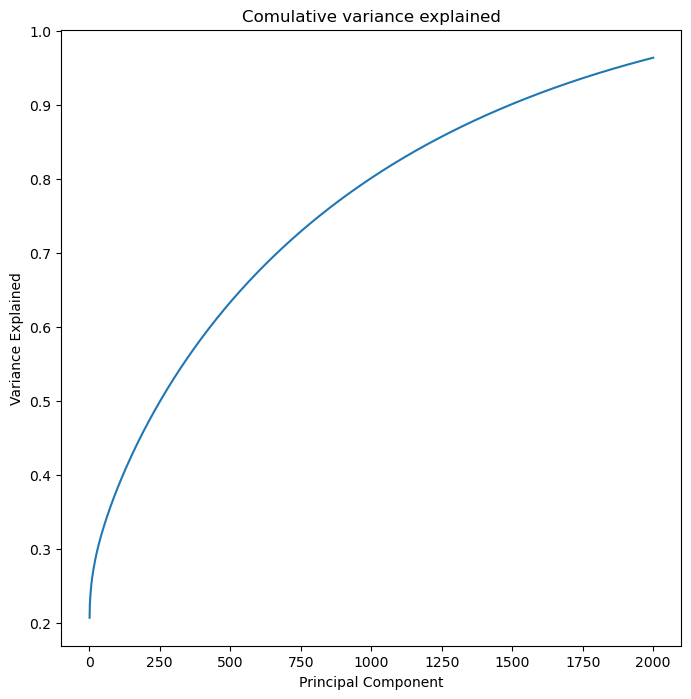

In [187]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

# number of components to visualize
n_components = 2000

axes.plot(
    np.arange(n_components) + 1,
    np.cumsum(thickness_pca.explained_variance_ratio_[:n_components]),
)

axes.set_title('Comulative variance explained')
axes.set_xlabel('Principal Component')
axes.set_ylabel('Variance Explained')

# axes.set_yscale('log')


## Provide informative visualizations of the thickness eigenmodes

---

In [11]:
from nilearn import datasets, surface, plotting


In [28]:
# load surfaces for visualization
left_surface_file = f'{main_dir}/data/templates/hcp_surf/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii'
left_surface = nib.load(left_surface_file)
right_surface_file = f'{main_dir}/data/templates/hcp_surf/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii'
right_surface = nib.load(right_surface_file)


In [163]:
# basic parameters
surface = 'inflated_MSMAll'
expand = 0

# load an example dscalar
dscalar_file = f'{main_dir}/data/templates/ones.dscalar.nii'
dscalar = nib.load(dscalar_file)

brain_models = [x for x in dscalar.header.get_index_map(1).brain_models]

# load surfaces for visualization
left_surface_file = f'{main_dir}/data/templates/hcp_surf/S1200.L.{surface}.32k_fs_LR.surf.gii'
left_surface = nib.load(left_surface_file)
right_surface_file = f'{main_dir}/data/templates/hcp_surf/S1200.R.{surface}.32k_fs_LR.surf.gii'
right_surface = nib.load(right_surface_file)

# extract surface information
lx, ly, lz = left_surface.darrays[0].data.T
lt = left_surface.darrays[1].data
rx, ry, rz = right_surface.darrays[0].data.T
rt = right_surface.darrays[1].data

# combine into a complete brain
ax = np.concatenate([lx - expand, rx + expand])
ay = np.concatenate([ly, ry])
az = np.concatenate([lz, rz])
at = np.concatenate([lt, (rt + lx.shape[0])])

lxyz = left_surface.darrays[0].data
rxyz = right_surface.darrays[0].data
axyz = np.array([ax, ay, az]).T

# create a mapping between surface and cifti vertices
left_cortical_surface_model, right_cortical_surface_model = brain_models[0], brain_models[1]
cifti_to_surface = {}
surface_to_cifti = {}
for (i, x) in enumerate(left_cortical_surface_model.vertex_indices):
    cifti_to_surface[i] = x
    surface_to_cifti[x] = i
for (i, x) in enumerate(right_cortical_surface_model.vertex_indices):
    cifti_to_surface[i + right_cortical_surface_model.index_offset] = x + rx.shape[0]
    surface_to_cifti[x + rx.shape[0]] = i + right_cortical_surface_model.index_offset

# construct data over surface
surface_mask = list(surface_to_cifti.keys())


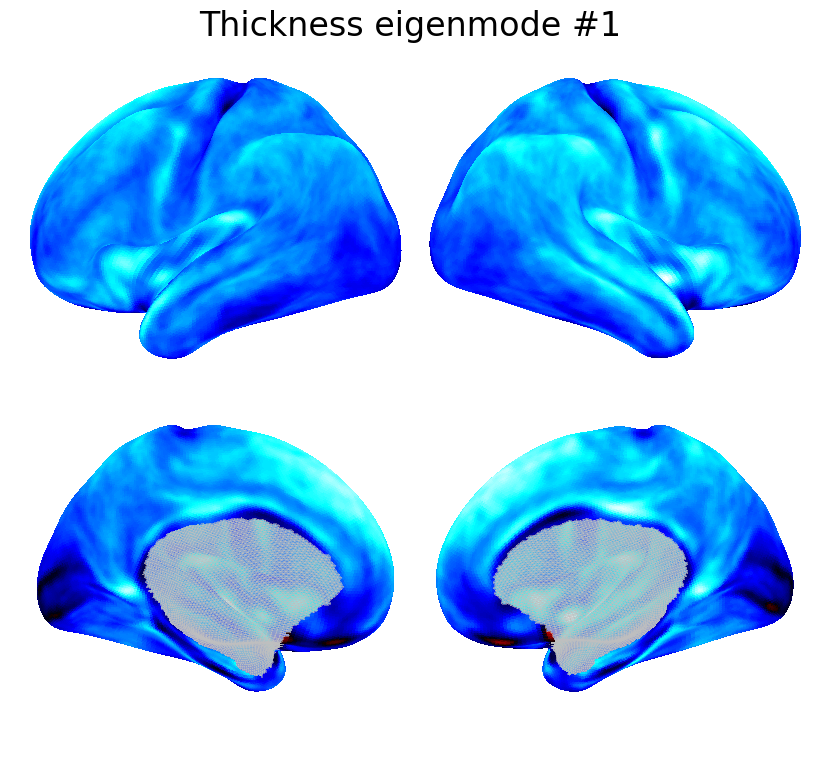

In [189]:
# data
eigenmode_idx = 0
data = thickness_pca.components_[eigenmode_idx]

# surface center
cxyz=(axyz.min(0) + axyz.max(0))/2

# transfer data to surface scalar
surface_scalars = np.empty(ax.shape[0])
surface_scalars[:] = np.nan
surface_scalars[surface_mask] = data.copy()

# decompose left and right information
left_surface_scalars = surface_scalars[:lx.shape[0]]
right_surface_scalars = surface_scalars[-rx.shape[0]:]


fig, axes = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={'projection': '3d'});

zoom_coeff = 0.85

# 'lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior'
plotting.plot_surf_stat_map(
    [lxyz-cxyz, lt],
    left_surface_scalars,
    axes=axes[0,0],
    view='lateral',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[0,0].set_xlim3d(np.array(axes[0,0].get_xlim3d())*zoom_coeff)
axes[0,0].set_ylim3d(np.array(axes[0,0].get_ylim3d())*zoom_coeff)
axes[0,0].set_zlim3d(np.array(axes[0,0].get_zlim3d())*zoom_coeff)

plotting.plot_surf_stat_map(
    [rxyz-cxyz, rt],
    right_surface_scalars,
    axes=axes[0,1],
    view='medial',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[0,1].set_xlim3d(np.array(axes[0,1].get_xlim3d())*zoom_coeff)
axes[0,1].set_ylim3d(np.array(axes[0,1].get_ylim3d())*zoom_coeff)
axes[0,1].set_zlim3d(np.array(axes[0,1].get_zlim3d())*zoom_coeff)


plotting.plot_surf_stat_map(
    [lxyz-cxyz, lt],
    left_surface_scalars,
    axes=axes[1,0],
    view='medial',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[1,0].set_xlim3d(np.array(axes[1,0].get_xlim3d())*zoom_coeff)
axes[1,0].set_ylim3d(np.array(axes[1,0].get_ylim3d())*zoom_coeff)
axes[1,0].set_zlim3d(np.array(axes[1,0].get_zlim3d())*zoom_coeff)

plotting.plot_surf_stat_map(
    [rxyz-cxyz, rt],
    right_surface_scalars,
    axes=axes[1,1],
    view='lateral',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[1,1].set_xlim3d(np.array(axes[1,1].get_xlim3d())*zoom_coeff)
axes[1,1].set_ylim3d(np.array(axes[1,1].get_ylim3d())*zoom_coeff)
axes[1,1].set_zlim3d(np.array(axes[1,1].get_zlim3d())*zoom_coeff)

fig.suptitle(f"Thickness eigenmode #{eigenmode_idx+1}", fontsize=24, y=0.98);
# fig.set_facecolor((0.7,0.7,0.7))
# fig.tight_layout()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=-0., hspace=-0.25)


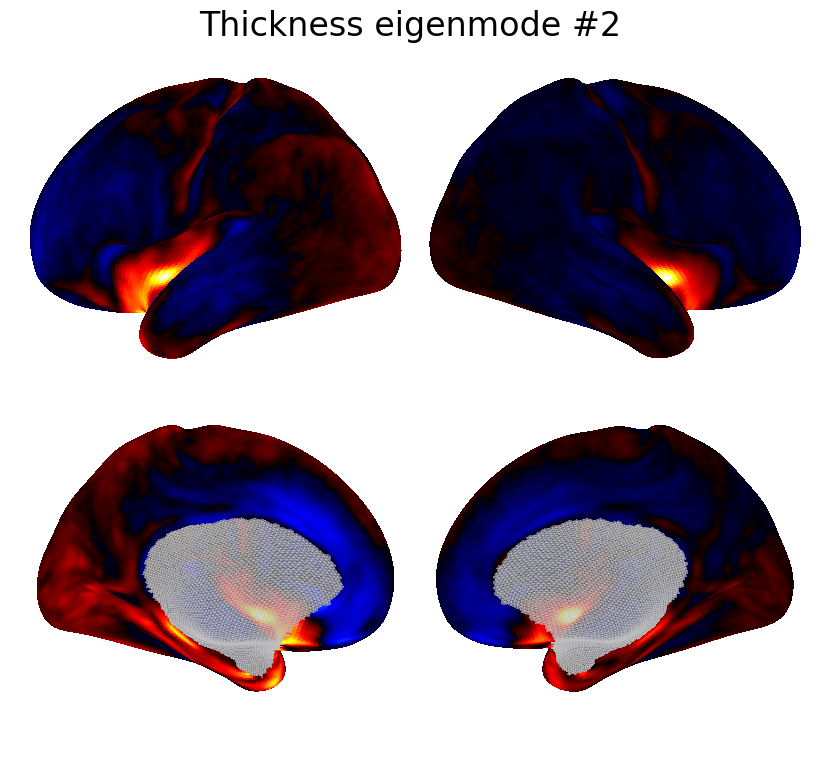

In [190]:
# data
eigenmode_idx = 1
data = thickness_pca.components_[eigenmode_idx]

# surface center
cxyz=(axyz.min(0) + axyz.max(0))/2

# transfer data to surface scalar
surface_scalars = np.empty(ax.shape[0])
surface_scalars[:] = np.nan
surface_scalars[surface_mask] = data.copy()

# decompose left and right information
left_surface_scalars = surface_scalars[:lx.shape[0]]
right_surface_scalars = surface_scalars[-rx.shape[0]:]


fig, axes = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={'projection': '3d'});

zoom_coeff = 0.85

# 'lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior'
plotting.plot_surf_stat_map(
    [lxyz-cxyz, lt],
    left_surface_scalars,
    axes=axes[0,0],
    view='lateral',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[0,0].set_xlim3d(np.array(axes[0,0].get_xlim3d())*zoom_coeff)
axes[0,0].set_ylim3d(np.array(axes[0,0].get_ylim3d())*zoom_coeff)
axes[0,0].set_zlim3d(np.array(axes[0,0].get_zlim3d())*zoom_coeff)

plotting.plot_surf_stat_map(
    [rxyz-cxyz, rt],
    right_surface_scalars,
    axes=axes[0,1],
    view='medial',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[0,1].set_xlim3d(np.array(axes[0,1].get_xlim3d())*zoom_coeff)
axes[0,1].set_ylim3d(np.array(axes[0,1].get_ylim3d())*zoom_coeff)
axes[0,1].set_zlim3d(np.array(axes[0,1].get_zlim3d())*zoom_coeff)


plotting.plot_surf_stat_map(
    [lxyz-cxyz, lt],
    left_surface_scalars,
    axes=axes[1,0],
    view='medial',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[1,0].set_xlim3d(np.array(axes[1,0].get_xlim3d())*zoom_coeff)
axes[1,0].set_ylim3d(np.array(axes[1,0].get_ylim3d())*zoom_coeff)
axes[1,0].set_zlim3d(np.array(axes[1,0].get_zlim3d())*zoom_coeff)

plotting.plot_surf_stat_map(
    [rxyz-cxyz, rt],
    right_surface_scalars,
    axes=axes[1,1],
    view='lateral',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[1,1].set_xlim3d(np.array(axes[1,1].get_xlim3d())*zoom_coeff)
axes[1,1].set_ylim3d(np.array(axes[1,1].get_ylim3d())*zoom_coeff)
axes[1,1].set_zlim3d(np.array(axes[1,1].get_zlim3d())*zoom_coeff)

fig.suptitle(f"Thickness eigenmode #{eigenmode_idx+1}", fontsize=24, y=0.98);
# fig.set_facecolor((0.7,0.7,0.7))
# fig.tight_layout()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=-0., hspace=-0.25)


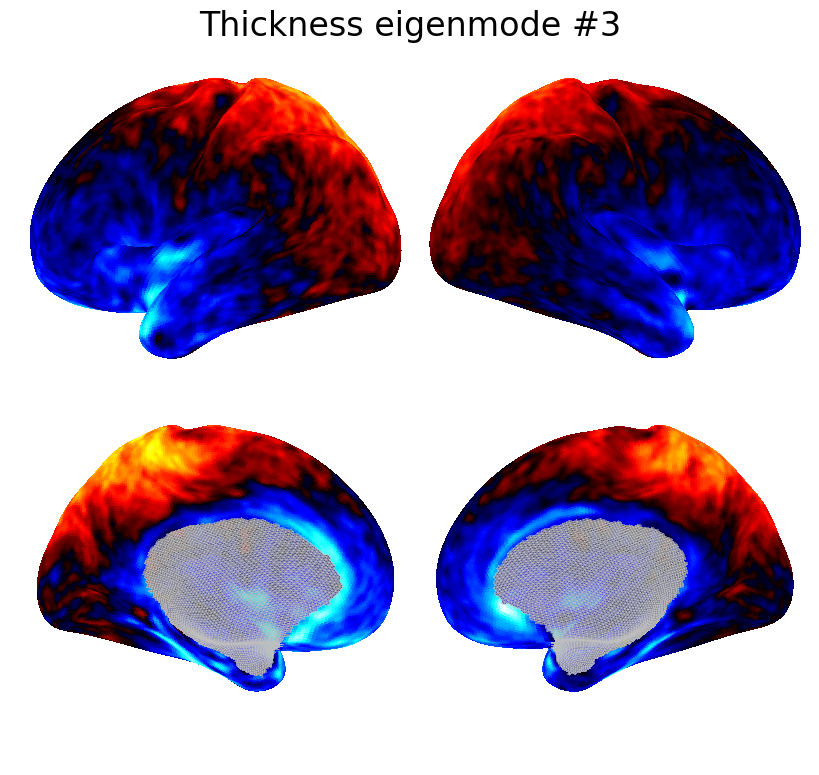

In [191]:
# data
eigenmode_idx = 2
data = thickness_pca.components_[eigenmode_idx]

# surface center
cxyz=(axyz.min(0) + axyz.max(0))/2

# transfer data to surface scalar
surface_scalars = np.empty(ax.shape[0])
surface_scalars[:] = np.nan
surface_scalars[surface_mask] = data.copy()

# decompose left and right information
left_surface_scalars = surface_scalars[:lx.shape[0]]
right_surface_scalars = surface_scalars[-rx.shape[0]:]


fig, axes = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={'projection': '3d'});

zoom_coeff = 0.85

# 'lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior'
plotting.plot_surf_stat_map(
    [lxyz-cxyz, lt],
    left_surface_scalars,
    axes=axes[0,0],
    view='lateral',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[0,0].set_xlim3d(np.array(axes[0,0].get_xlim3d())*zoom_coeff)
axes[0,0].set_ylim3d(np.array(axes[0,0].get_ylim3d())*zoom_coeff)
axes[0,0].set_zlim3d(np.array(axes[0,0].get_zlim3d())*zoom_coeff)

plotting.plot_surf_stat_map(
    [rxyz-cxyz, rt],
    right_surface_scalars,
    axes=axes[0,1],
    view='medial',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[0,1].set_xlim3d(np.array(axes[0,1].get_xlim3d())*zoom_coeff)
axes[0,1].set_ylim3d(np.array(axes[0,1].get_ylim3d())*zoom_coeff)
axes[0,1].set_zlim3d(np.array(axes[0,1].get_zlim3d())*zoom_coeff)


plotting.plot_surf_stat_map(
    [lxyz-cxyz, lt],
    left_surface_scalars,
    axes=axes[1,0],
    view='medial',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[1,0].set_xlim3d(np.array(axes[1,0].get_xlim3d())*zoom_coeff)
axes[1,0].set_ylim3d(np.array(axes[1,0].get_ylim3d())*zoom_coeff)
axes[1,0].set_zlim3d(np.array(axes[1,0].get_zlim3d())*zoom_coeff)

plotting.plot_surf_stat_map(
    [rxyz-cxyz, rt],
    right_surface_scalars,
    axes=axes[1,1],
    view='lateral',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[1,1].set_xlim3d(np.array(axes[1,1].get_xlim3d())*zoom_coeff)
axes[1,1].set_ylim3d(np.array(axes[1,1].get_ylim3d())*zoom_coeff)
axes[1,1].set_zlim3d(np.array(axes[1,1].get_zlim3d())*zoom_coeff)

fig.suptitle(f"Thickness eigenmode #{eigenmode_idx+1}", fontsize=24, y=0.98);
# fig.set_facecolor((0.7,0.7,0.7))
# fig.tight_layout()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=-0., hspace=-0.25)


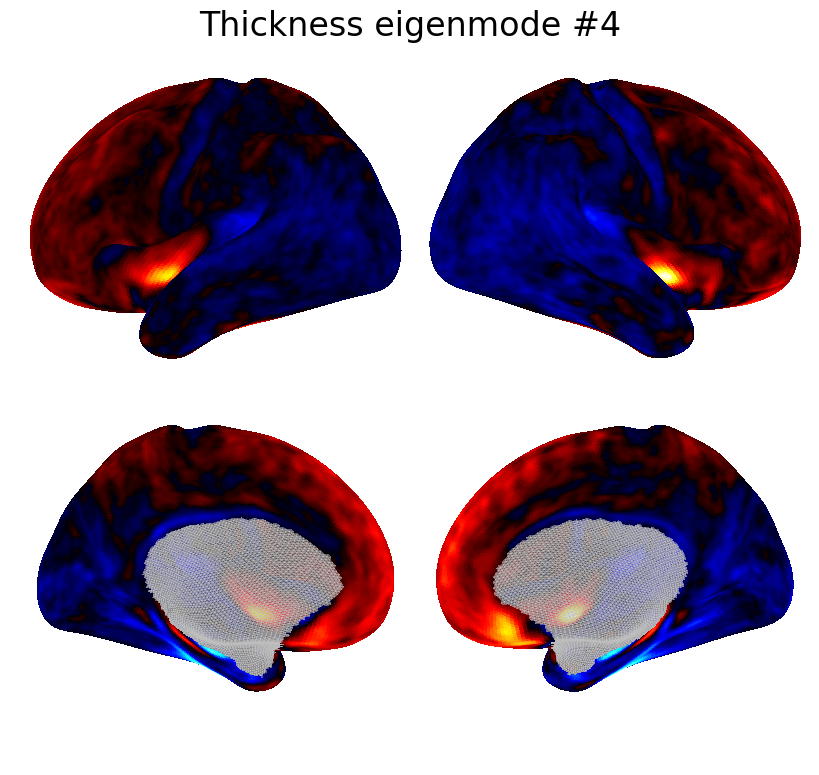

In [193]:
# data
eigenmode_idx = 3
data = thickness_pca.components_[eigenmode_idx]

# surface center
cxyz=(axyz.min(0) + axyz.max(0))/2

# transfer data to surface scalar
surface_scalars = np.empty(ax.shape[0])
surface_scalars[:] = np.nan
surface_scalars[surface_mask] = data.copy()

# decompose left and right information
left_surface_scalars = surface_scalars[:lx.shape[0]]
right_surface_scalars = surface_scalars[-rx.shape[0]:]


fig, axes = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={'projection': '3d'});

zoom_coeff = 0.85

# 'lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior'
plotting.plot_surf_stat_map(
    [lxyz-cxyz, lt],
    left_surface_scalars,
    axes=axes[0,0],
    view='lateral',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[0,0].set_xlim3d(np.array(axes[0,0].get_xlim3d())*zoom_coeff)
axes[0,0].set_ylim3d(np.array(axes[0,0].get_ylim3d())*zoom_coeff)
axes[0,0].set_zlim3d(np.array(axes[0,0].get_zlim3d())*zoom_coeff)

plotting.plot_surf_stat_map(
    [rxyz-cxyz, rt],
    right_surface_scalars,
    axes=axes[0,1],
    view='medial',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[0,1].set_xlim3d(np.array(axes[0,1].get_xlim3d())*zoom_coeff)
axes[0,1].set_ylim3d(np.array(axes[0,1].get_ylim3d())*zoom_coeff)
axes[0,1].set_zlim3d(np.array(axes[0,1].get_zlim3d())*zoom_coeff)


plotting.plot_surf_stat_map(
    [lxyz-cxyz, lt],
    left_surface_scalars,
    axes=axes[1,0],
    view='medial',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[1,0].set_xlim3d(np.array(axes[1,0].get_xlim3d())*zoom_coeff)
axes[1,0].set_ylim3d(np.array(axes[1,0].get_ylim3d())*zoom_coeff)
axes[1,0].set_zlim3d(np.array(axes[1,0].get_zlim3d())*zoom_coeff)

plotting.plot_surf_stat_map(
    [rxyz-cxyz, rt],
    right_surface_scalars,
    axes=axes[1,1],
    view='lateral',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[1,1].set_xlim3d(np.array(axes[1,1].get_xlim3d())*zoom_coeff)
axes[1,1].set_ylim3d(np.array(axes[1,1].get_ylim3d())*zoom_coeff)
axes[1,1].set_zlim3d(np.array(axes[1,1].get_zlim3d())*zoom_coeff)

fig.suptitle(f"Thickness eigenmode #{eigenmode_idx+1}", fontsize=24, y=0.98);
# fig.set_facecolor((0.7,0.7,0.7))
# fig.tight_layout()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=-0., hspace=-0.25)


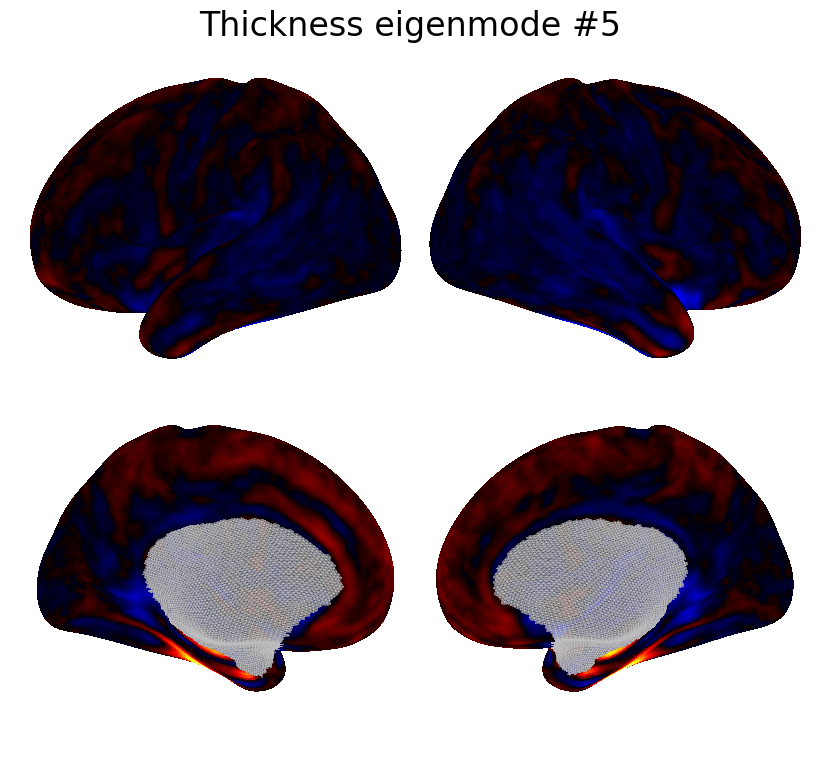

In [192]:
# data
eigenmode_idx = 4
data = thickness_pca.components_[eigenmode_idx]

# surface center
cxyz=(axyz.min(0) + axyz.max(0))/2

# transfer data to surface scalar
surface_scalars = np.empty(ax.shape[0])
surface_scalars[:] = np.nan
surface_scalars[surface_mask] = data.copy()

# decompose left and right information
left_surface_scalars = surface_scalars[:lx.shape[0]]
right_surface_scalars = surface_scalars[-rx.shape[0]:]


fig, axes = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={'projection': '3d'});

zoom_coeff = 0.85

# 'lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior'
plotting.plot_surf_stat_map(
    [lxyz-cxyz, lt],
    left_surface_scalars,
    axes=axes[0,0],
    view='lateral',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[0,0].set_xlim3d(np.array(axes[0,0].get_xlim3d())*zoom_coeff)
axes[0,0].set_ylim3d(np.array(axes[0,0].get_ylim3d())*zoom_coeff)
axes[0,0].set_zlim3d(np.array(axes[0,0].get_zlim3d())*zoom_coeff)

plotting.plot_surf_stat_map(
    [rxyz-cxyz, rt],
    right_surface_scalars,
    axes=axes[0,1],
    view='medial',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[0,1].set_xlim3d(np.array(axes[0,1].get_xlim3d())*zoom_coeff)
axes[0,1].set_ylim3d(np.array(axes[0,1].get_ylim3d())*zoom_coeff)
axes[0,1].set_zlim3d(np.array(axes[0,1].get_zlim3d())*zoom_coeff)


plotting.plot_surf_stat_map(
    [lxyz-cxyz, lt],
    left_surface_scalars,
    axes=axes[1,0],
    view='medial',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[1,0].set_xlim3d(np.array(axes[1,0].get_xlim3d())*zoom_coeff)
axes[1,0].set_ylim3d(np.array(axes[1,0].get_ylim3d())*zoom_coeff)
axes[1,0].set_zlim3d(np.array(axes[1,0].get_zlim3d())*zoom_coeff)

plotting.plot_surf_stat_map(
    [rxyz-cxyz, rt],
    right_surface_scalars,
    axes=axes[1,1],
    view='lateral',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[1,1].set_xlim3d(np.array(axes[1,1].get_xlim3d())*zoom_coeff)
axes[1,1].set_ylim3d(np.array(axes[1,1].get_ylim3d())*zoom_coeff)
axes[1,1].set_zlim3d(np.array(axes[1,1].get_zlim3d())*zoom_coeff)

fig.suptitle(f"Thickness eigenmode #{eigenmode_idx+1}", fontsize=24, y=0.98);
# fig.set_facecolor((0.7,0.7,0.7))
# fig.tight_layout()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=-0., hspace=-0.25)


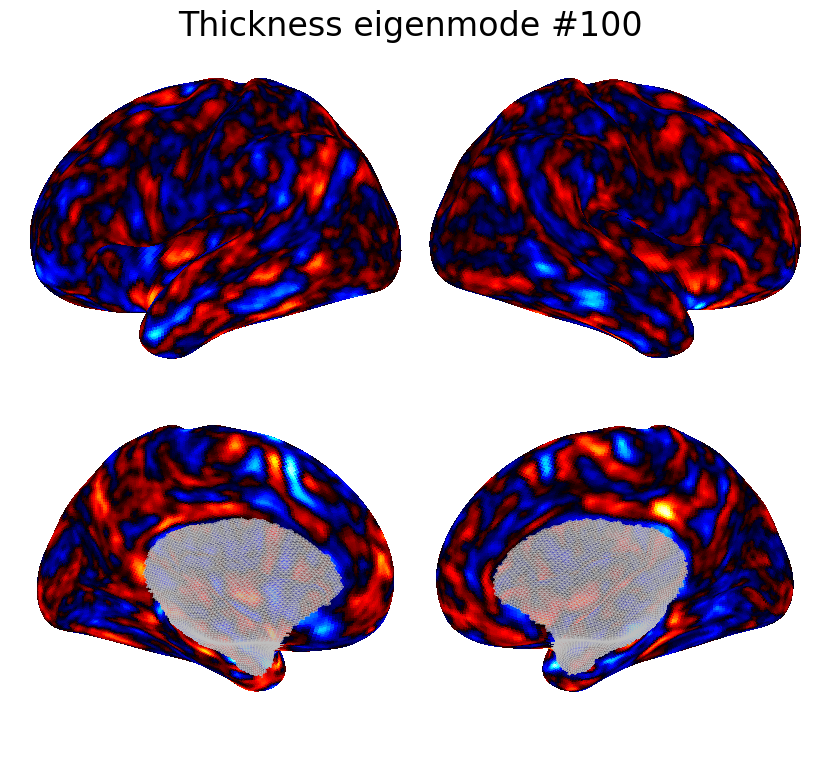

In [195]:
# data
eigenmode_idx = 99
data = thickness_pca.components_[eigenmode_idx]

# surface center
cxyz=(axyz.min(0) + axyz.max(0))/2

# transfer data to surface scalar
surface_scalars = np.empty(ax.shape[0])
surface_scalars[:] = np.nan
surface_scalars[surface_mask] = data.copy()

# decompose left and right information
left_surface_scalars = surface_scalars[:lx.shape[0]]
right_surface_scalars = surface_scalars[-rx.shape[0]:]


fig, axes = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={'projection': '3d'});

zoom_coeff = 0.85

# 'lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior'
plotting.plot_surf_stat_map(
    [lxyz-cxyz, lt],
    left_surface_scalars,
    axes=axes[0,0],
    view='lateral',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[0,0].set_xlim3d(np.array(axes[0,0].get_xlim3d())*zoom_coeff)
axes[0,0].set_ylim3d(np.array(axes[0,0].get_ylim3d())*zoom_coeff)
axes[0,0].set_zlim3d(np.array(axes[0,0].get_zlim3d())*zoom_coeff)

plotting.plot_surf_stat_map(
    [rxyz-cxyz, rt],
    right_surface_scalars,
    axes=axes[0,1],
    view='medial',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[0,1].set_xlim3d(np.array(axes[0,1].get_xlim3d())*zoom_coeff)
axes[0,1].set_ylim3d(np.array(axes[0,1].get_ylim3d())*zoom_coeff)
axes[0,1].set_zlim3d(np.array(axes[0,1].get_zlim3d())*zoom_coeff)


plotting.plot_surf_stat_map(
    [lxyz-cxyz, lt],
    left_surface_scalars,
    axes=axes[1,0],
    view='medial',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[1,0].set_xlim3d(np.array(axes[1,0].get_xlim3d())*zoom_coeff)
axes[1,0].set_ylim3d(np.array(axes[1,0].get_ylim3d())*zoom_coeff)
axes[1,0].set_zlim3d(np.array(axes[1,0].get_zlim3d())*zoom_coeff)

plotting.plot_surf_stat_map(
    [rxyz-cxyz, rt],
    right_surface_scalars,
    axes=axes[1,1],
    view='lateral',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[1,1].set_xlim3d(np.array(axes[1,1].get_xlim3d())*zoom_coeff)
axes[1,1].set_ylim3d(np.array(axes[1,1].get_ylim3d())*zoom_coeff)
axes[1,1].set_zlim3d(np.array(axes[1,1].get_zlim3d())*zoom_coeff)

fig.suptitle(f"Thickness eigenmode #{eigenmode_idx+1}", fontsize=24, y=0.98);
# fig.set_facecolor((0.7,0.7,0.7))
# fig.tight_layout()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=-0., hspace=-0.25)


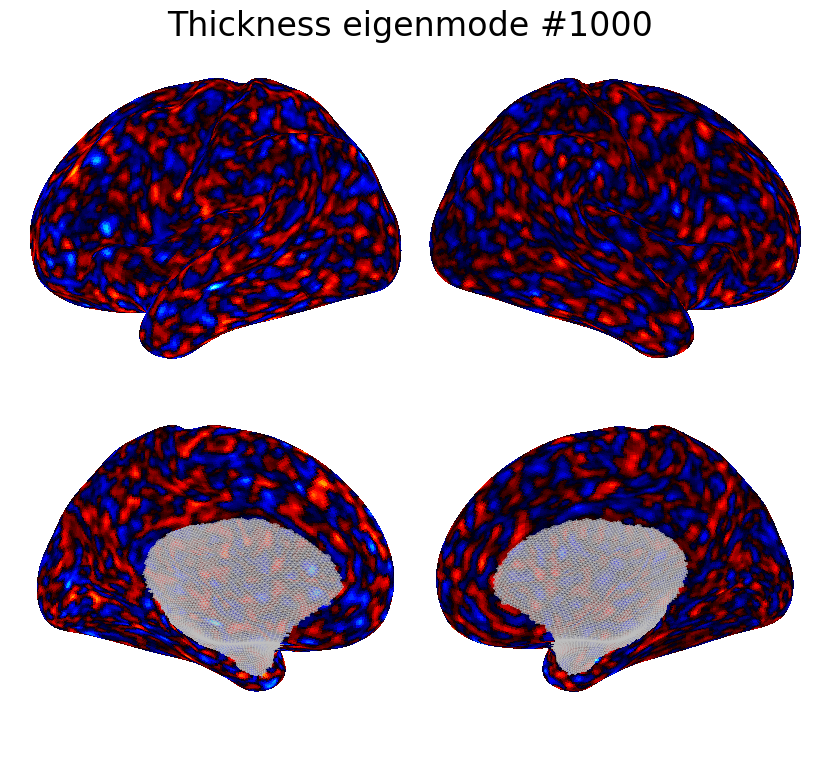

In [194]:
# data
eigenmode_idx = 999
data = thickness_pca.components_[eigenmode_idx]

# surface center
cxyz=(axyz.min(0) + axyz.max(0))/2

# transfer data to surface scalar
surface_scalars = np.empty(ax.shape[0])
surface_scalars[:] = np.nan
surface_scalars[surface_mask] = data.copy()

# decompose left and right information
left_surface_scalars = surface_scalars[:lx.shape[0]]
right_surface_scalars = surface_scalars[-rx.shape[0]:]


fig, axes = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={'projection': '3d'});

zoom_coeff = 0.85

# 'lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior'
plotting.plot_surf_stat_map(
    [lxyz-cxyz, lt],
    left_surface_scalars,
    axes=axes[0,0],
    view='lateral',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[0,0].set_xlim3d(np.array(axes[0,0].get_xlim3d())*zoom_coeff)
axes[0,0].set_ylim3d(np.array(axes[0,0].get_ylim3d())*zoom_coeff)
axes[0,0].set_zlim3d(np.array(axes[0,0].get_zlim3d())*zoom_coeff)

plotting.plot_surf_stat_map(
    [rxyz-cxyz, rt],
    right_surface_scalars,
    axes=axes[0,1],
    view='medial',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[0,1].set_xlim3d(np.array(axes[0,1].get_xlim3d())*zoom_coeff)
axes[0,1].set_ylim3d(np.array(axes[0,1].get_ylim3d())*zoom_coeff)
axes[0,1].set_zlim3d(np.array(axes[0,1].get_zlim3d())*zoom_coeff)


plotting.plot_surf_stat_map(
    [lxyz-cxyz, lt],
    left_surface_scalars,
    axes=axes[1,0],
    view='medial',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[1,0].set_xlim3d(np.array(axes[1,0].get_xlim3d())*zoom_coeff)
axes[1,0].set_ylim3d(np.array(axes[1,0].get_ylim3d())*zoom_coeff)
axes[1,0].set_zlim3d(np.array(axes[1,0].get_zlim3d())*zoom_coeff)

plotting.plot_surf_stat_map(
    [rxyz-cxyz, rt],
    right_surface_scalars,
    axes=axes[1,1],
    view='lateral',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[1,1].set_xlim3d(np.array(axes[1,1].get_xlim3d())*zoom_coeff)
axes[1,1].set_ylim3d(np.array(axes[1,1].get_ylim3d())*zoom_coeff)
axes[1,1].set_zlim3d(np.array(axes[1,1].get_zlim3d())*zoom_coeff)

fig.suptitle(f"Thickness eigenmode #{eigenmode_idx+1}", fontsize=24, y=0.98);
# fig.set_facecolor((0.7,0.7,0.7))
# fig.tight_layout()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=-0., hspace=-0.25)


In [ ]:
# data
eigenmode_idx = 0
data = thickness_pca_kernel[eigenmode_idx]

# transfer data to surface scalar
surface_scalars = np.empty(ax.shape[0])
surface_scalars[:] = np.nan
surface_scalars[surface_mask] = data.copy()


fig, axes = plt.subplots(1, 2, figsize=(16, 10), subplot_kw={'projection': '3d'});

zoom_coeff = 0.85

# 'lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior'
plotting.plot_surf_stat_map(
    [axyz, at],
    surface_scalars,
    axes=axes[0],
    view='lateral',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[0].set_xlim3d(np.array(axes[0].get_xlim3d())*zoom_coeff)
axes[0].set_ylim3d(np.array(axes[0].get_ylim3d())*zoom_coeff)
axes[0].set_zlim3d(np.array(axes[0].get_zlim3d())*zoom_coeff)

plotting.plot_surf_stat_map(
    [axyz, at],
    surface_scalars,
    axes=axes[1],
    view='medial',
    colorbar=False,
    symmetric_cbar=True,
    darkness=0.5,
);
axes[1].set_xlim3d(np.array(axes[1].get_xlim3d())*zoom_coeff)
axes[1].set_ylim3d(np.array(axes[1].get_ylim3d())*zoom_coeff)
axes[1].set_zlim3d(np.array(axes[1].get_zlim3d())*zoom_coeff)

fig.suptitle(f"Thickness eigenmode #{eigenmode_idx+1}", fontsize=24, y=0.8);


In [ ]:
# plotly renderer, 3D interactive render, though very slow
fig = plotting.plot_surf_stat_map(
    [axyz, at],
    surface_scalars,
    axes=axes[0],
    view='medial',
    # view='lateral',
    engine='plotly',
);
fig.show(renderer='notebook')


## Projection of the mean thickness information over the generated kernel

---

Mean thickness can be viewed as a vector with a length of number of vertices $N_v$ where all elements have an equal weight of $\frac{1}{N_v}$.

Here, we visualize the loading of mean thickness, as well as its energy distribution over eigenmodes:

In [203]:
# define the mean thickness operation
mean_thickness_vector = np.ones(thickness_pca.components_.shape[1])/thickness_pca.components_.shape[1]

mean_thickness_vector_encoded = np.dot(thickness_pca.components_, mean_thickness_vector,)


In [204]:
mean_thickness_vector_encoded.shape

(2473,)

In [215]:
# check validity by comparison of signal energy
np.power(mean_thickness_vector_encoded, 2).sum(), np.power(mean_thickness_vector, 2).sum()


(1.6711578589291315e-05, 1.683161650844947e-05)

Text(0, 0.5, 'Loading (eigenmode coefficient)')

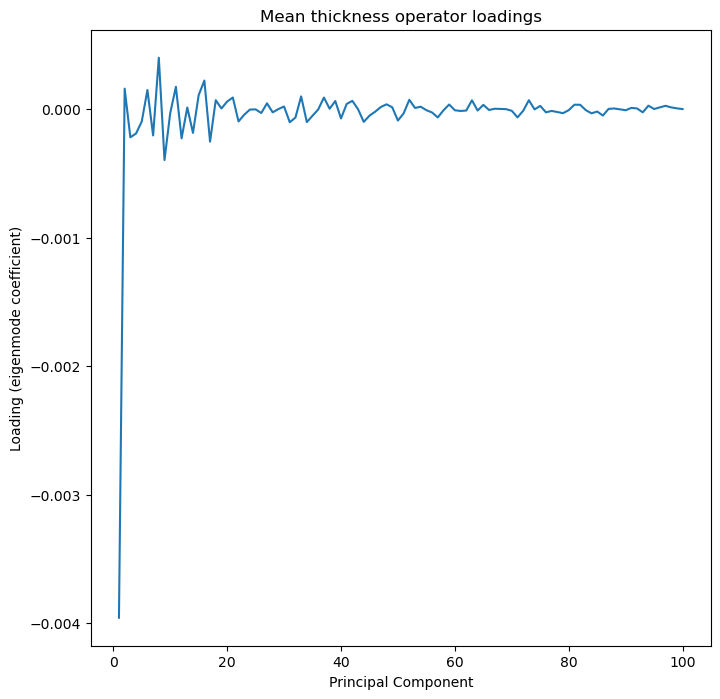

In [207]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

# number of components to visualize
n_components = 100

axes.plot(
    np.arange(n_components) + 1,
    mean_thickness_vector_encoded[:n_components],
)

axes.set_title('Mean thickness operator loadings')
axes.set_xlabel('Principal Component')
axes.set_ylabel('Loading (eigenmode coefficient)')

# axes.set_yscale('log')


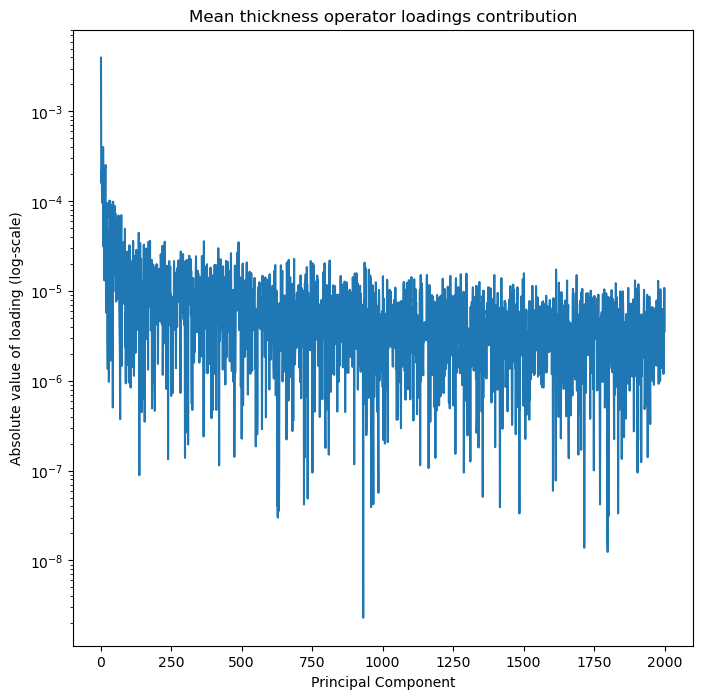

In [216]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

# number of components to visualize
n_components = 2000

axes.plot(
    np.arange(n_components) + 1,
    np.abs(mean_thickness_vector_encoded[:n_components]),
)

axes.set_title('Mean thickness operator loadings contribution')
axes.set_xlabel('Principal Component')
axes.set_ylabel('Absolute value of loading (log-scale)')

axes.set_yscale('log')


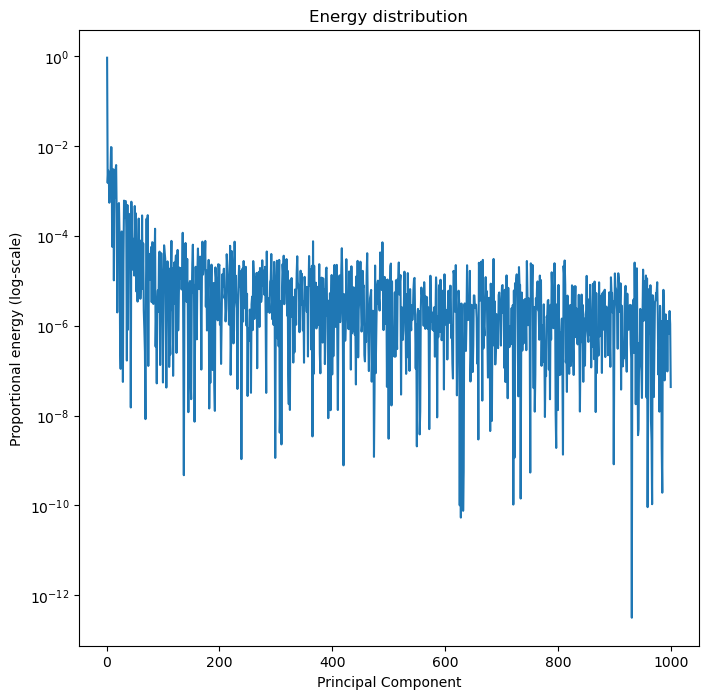

In [221]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

# number of components to visualize
n_components = 1000

axes.plot(
    np.arange(n_components) + 1,
    np.power(mean_thickness_vector_encoded[:n_components], 2) / np.power(mean_thickness_vector, 2).sum(),
)

axes.set_title('Energy distribution')
axes.set_xlabel('Principal Component')
axes.set_ylabel('Proportional energy (log-scale)')

axes.set_yscale('log')


Text(0, 0.5, 'Proportional energy')

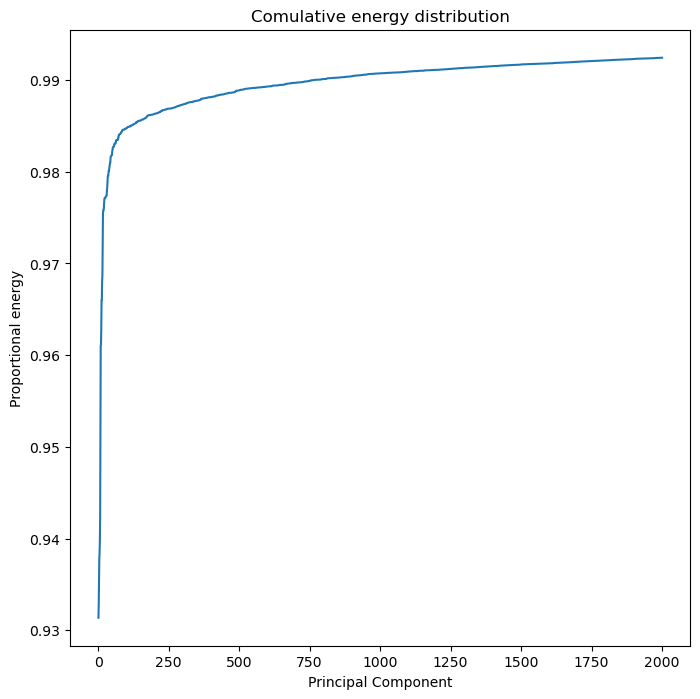

In [223]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

# number of components to visualize
n_components = 2000

axes.plot(
    np.arange(n_components) + 1,
    np.cumsum(np.power(mean_thickness_vector_encoded[:n_components], 2)) / np.power(mean_thickness_vector, 2).sum(),
)

axes.set_title('Comulative energy distribution')
axes.set_xlabel('Principal Component')
axes.set_ylabel('Proportional energy')

# axes.set_yscale('log')
